## Second hand car data. Classification and regression with ANN.

Author: Joaquim Quadrada Jané
Date: 05/02/2023

In this jupyter notebook we will analyse the data from a second hand car dataset, and use neuronal networks for classification and regression.

In [47]:
# Install libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import os

import keras
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
# set seeds for repeatibility results
from numpy.random import seed
seed(10)
import tensorflow as tf
tf.random.set_seed(100)

# read dataset
current_dir = os.getcwd()
dataset_path = os.path.join(current_dir, "dataset.csv")

df1 = pd.read_csv(dataset_path)

In [3]:
df1.head(5)

,months_old,km,fuel_type,horsepower,metcolor,automatic,size_engine,doors_num,weight,price
0,73,97494,Petrol,110,1,0,1600,5,1085,10950
1,48,89049,Petrol,97,1,0,1400,5,1060,13500
2,40,161000,Diesel,69,1,0,1900,3,1105,13950
3,37,38812,Petrol,97,0,0,1400,3,1025,13450
4,55,33230,Petrol,110,0,0,1600,3,1050,13500


## 1. Exploration

Lets check what kind of data we have.



*   **Variables**



In [4]:
#Dataset size
df1.shape

(1436, 10)

In [5]:
#Number of categorical and continuous variables
num_categorical_variables = 4
num_continuous_variables = 6

*   **Variable Distributions**

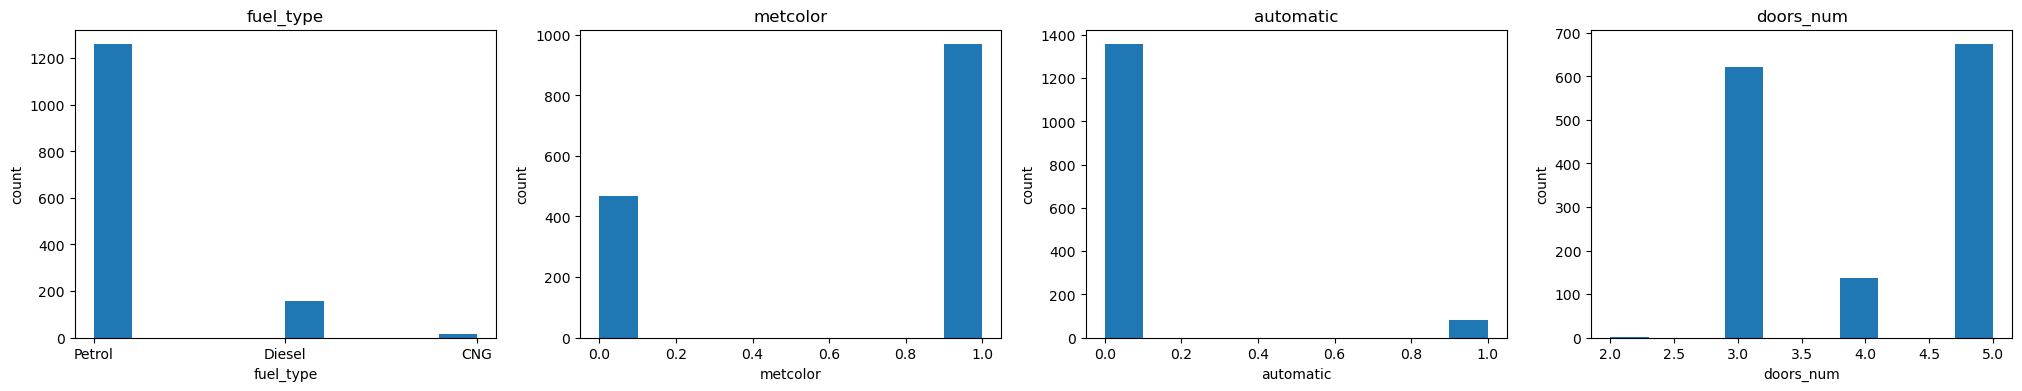

In [6]:
#Distributions of categorical variables

# Lists with categorical variables names
categorical_variables = ['fuel_type', 'metcolor', 'automatic', 'doors_num']

# plot of the histograms
fig, ax = plt.subplots(nrows=1, ncols=num_categorical_variables, figsize=(25,4))

ax = ax.ravel()
for idx,a in enumerate(ax):
    a.hist(df1[categorical_variables[idx]])
    a.set_title(categorical_variables[idx])
    a.set_xlabel(categorical_variables[idx])
    a.set_ylabel('count')


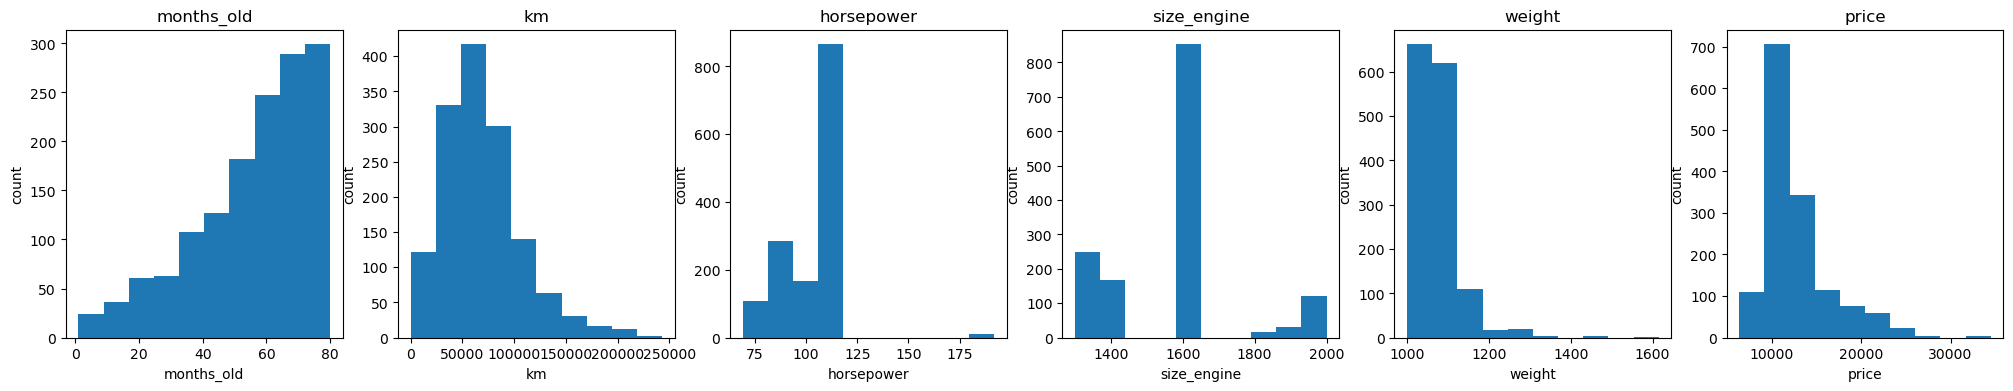

In [7]:
#Distributions continuous variables

# list with continuous variables names
continuous_variables = ['months_old', 'km', 'horsepower', 'size_engine', 'weight', 'price']

# plot of the histograms
fig, ax = plt.subplots(nrows=1, ncols=num_continuous_variables, figsize=(25,4))

ax = ax.ravel()
for idx,a in enumerate(ax):
    a.hist(df1[continuous_variables[idx]])
    a.set_title(continuous_variables[idx])
    a.set_xlabel(continuous_variables[idx])
    a.set_ylabel('count')

*   **Correlations**

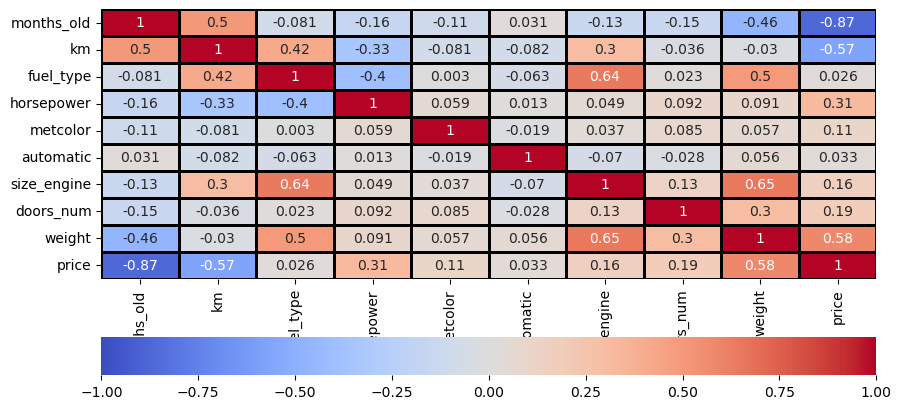

In [8]:
#All variables correlations

# convert fuel_type to numeric factor
df1['fuel_type'] = pd.factorize(df1['fuel_type'])[0]

# make copy of dataframe (for correlation exercice)
df = df1

# show correlation matrix with values
def plot_cor_matrix(corr, x_size, mask=None):
    f, ax = plt.subplots(figsize=(x_size, 5))
    sns.heatmap(corr, ax=ax,
                mask=mask,
                # cosmetics
                annot=True, vmin=-1, vmax=1, center=0,
                cmap='coolwarm', linewidths=2, linecolor='black', cbar_kws={'orientation': 'horizontal'})

corr = df.corr()
plot_cor_matrix(corr,10)
plt.show()

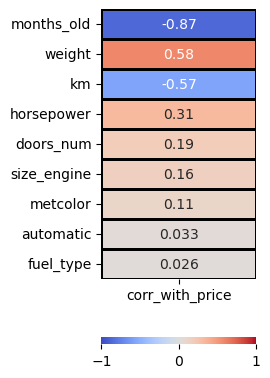

In [9]:
#Features correlating with Price
corr = df.drop("price", axis=1).apply(lambda x: x.corr(df.price)).to_frame()
corr.rename(columns={0 :'corr_with_price'}, inplace=True)
corr = corr.reindex(abs(corr.corr_with_price).sort_values(ascending=False).index)

# show correlations of each variable with price, sorted by absolute value
plot_cor_matrix(corr,2)
plt.show()

**Comments**

We observe the dimension of the dataset using df.shape, which is 1436 entries and 10 columns. Regarding the number of non-numeric categorical variables, we consider the categorical variables to be 'fuel_type', 'metcolor', 'automatic', and 'doors_num'. We do not consider 'horse_power' and 'size_engine' to be categorical variables despite having few unique values, but rather discrete numeric variables, as they have a countable number of values between two numbers. This means that possible values between two included values in the 'horse_power' attribute make sense (for example, there could be 102 horsepower engines, which would be between 97 and 110; or there could be 1555cc engines, a value between 1400 and 1600 of 'size_engine'). On the other hand, there cannot be 3.5 doors, 0.5 metallic paints, 0.75 automatic transmissions, or a mixture of gasoline and diesel fuel. The rest of the variables along with 'horse_power' and 'size_engine' are numeric.

In order to make the correlation matrix, we converted the text categorical 'fuel_type' to numeric with the following relationship:

- Petrol -> 0
- Diesel -> 1
- CNG -> 2

From the data analysis, we see:

fuel_type: Most vehicles are diesel
metcolor: approximately 2/3 are metallic and 1/3 not
automatic: Most vehicles are not automatic
doors_num: Most vehicles are distributed between 3 and 5 doors
months_old: We see that the vehicle fleet is old, as the density curve is very skewed to the right, to the maximum values of age.
km: the distribution of kilometers is centered approximately at 60,000 km, although there are vehicles with many more km.
horse_power: Most vehicles do not exceed 115 horses, although there are some with much greater power (but they are isolated values)
size_engine: The engine size is mostly 1600cc
weight: The weight is mostly between 1000 and 1100kg
price: The price distribution follows a left-skewed distribution, centered approximately at 11000€.
From the correlation analysis, we see that the maximum is in the correlation between price and age (-0.87), followed by weight and engine size (0.65) and engine size and fuel type (0.64). Strong correlations that seem logical.

If we look at the correlations of the price variable, we see that the most correlated are age (-0.87, negative, so the older the vehicle, the lower the price), followed by weight (0.58, positive, so the heavier the vehicle, the higher the price) and km (-0.57, negative, so the greater the km, the lower the price). These correlations follow the logic of second-hand vehicles.

## 2. Artificial Neural Network: Classification


In this section, we will train a model that tries to classify cars according to the price range. To do this, we will create a new variable as a car quality indicator (low-end, medium, or high-end), following the following conditions:

- low-end: price less than 11000 euros
- medium-end: price greater than or equal to 11000 euros and less than 13000
- high-end: price greater than or equal to 13000

### Pre-processing


In [10]:
#Create new variable: quality
df.loc[df['price'] < 11000, 'quality'] = 'low-end'
df.loc[(df['price'] >= 11000) & (df['price'] < 130000), 'quality'] = 'medium-end'
df.loc[df['price'] >= 13000, 'quality'] = 'high-end'

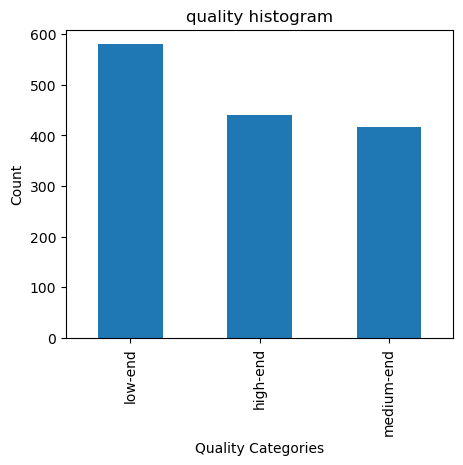

In [11]:
#Histogram car quality
plt.figure(figsize=(5, 4))
df['quality'].value_counts().plot(kind="bar", title="quality count")
plt.title("quality histogram")
plt.xlabel("Quality Categories")
plt.ylabel("Count")
plt.show()

In [12]:
#Create features and labels vectors
features = df.iloc[:,:9].values
labels = df.iloc[:, 10:11].values

In [13]:
#Normalize the corresponding data
features = StandardScaler().fit_transform(features)

In [14]:
#Binarize the labels
ohe = OneHotEncoder()
labels_bin = ohe.fit_transform(labels).toarray()

In [15]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels_bin, test_size=0.2)

In [16]:
#Shapes
print("train feature dimensions: ",X_train.shape)
print("train labels dimensions: ",y_train.shape)
print("test feature dimensions: ",X_test.shape)
print("test labels dimensions: ",y_test.shape)

train feature dimensions:  (1148, 9)
train labels dimensions:  (1148, 3)
test feature dimensions:  (288, 9)
test labels dimensions:  (288, 3)


### Basis model

Implement the artificial neural network model:
Design the architecture for the classification model with the appropriate activation function for the output layer and with the following features:

- 4 hidden layers with 64, 32, 10, and 8 neurons successively.
- Activation function for the intermediate layers: ReLU.
- Compile the model with the most appropriate loss function, the Adam optimizer, a learning rate of 0.1, and the Accuracy metric.
- Fit the model with 20 epochs and a batch size of 64.
- Accuracy and loss graphs ar shown. On each graph, the training curve and the validation curve is displayed.

In [17]:
#Create ANN model
model = Sequential()
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(3, activation="softmax"))

In [18]:
#Compile
# Cross-entropy is the default loss function to use for binary classification problems.
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [19]:
# ini epochs count
epoch_num = 30

#Fit
history = model.fit(X_train, y_train, epochs=epoch_num, batch_size=64, validation_data=(X_test, y_test), verbose = 0,)

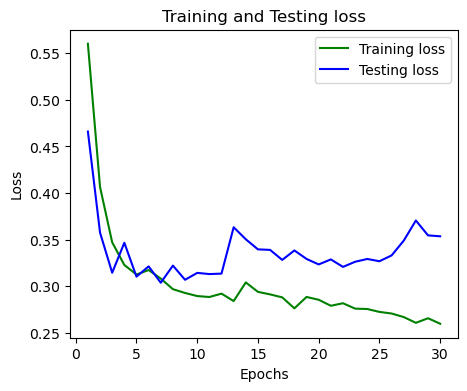

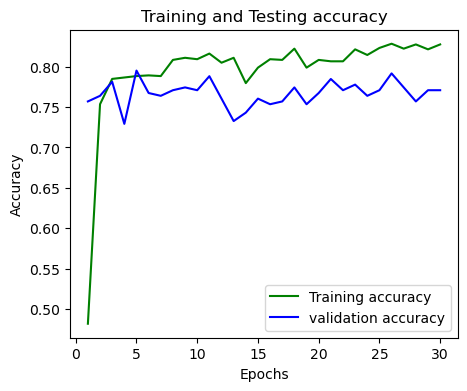

In [20]:
#Plots
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,epoch_num+1)
plt.figure(figsize=(5, 4))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Testing loss')
plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,epoch_num+1)
plt.figure(figsize=(5, 4))
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Influence of learning rate and optimizer

Once the base model is implemented, the influence that the learning rate and optimizer can have on performance improvement will be analyzed.

A function is implemented to train the architecture from the previous exercise with four different optimizers: Adam, SGD, Adadelta, Adagrad, and four learning rates: 0.001, 0.01, 0.05, 0.1. The models are trained and two graphs are plotted:

- Training time vs Learning rate
- Accuracy vs Learning rate

Each graph includes the evolution obtained by the four optimizers for better comparison.

In [21]:
#Function to compute several models changing Optimizers and learning rate
def training(optims,speeds):
    #Create ANN model
    model = Sequential()
    model.add(Dense(64, activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(3, activation="softmax"))
    # initialize results
    data = pd.DataFrame({'accuracy': [], 'time': [], 'optimizer': [], 'speed': []})
    all_histories = pd.DataFrame(data)
    idx = 0
    for optimizer in optims:
        for speed in speeds:
            idx += 1
            # set up model
            model.compile(loss='binary_crossentropy', optimizer=optimizer(learning_rate=speed), metrics=['accuracy'])
            # train and chrono
            start=timeit.default_timer()
            history = model.fit(X_train, y_train, epochs=epoch_num, batch_size=64, verbose = 0)
            end=timeit.default_timer()
            # save all variables to tuple
            new_row = pd.DataFrame({'accuracy': [history.history['accuracy'][-1]],
                                    'time': [end-start], 'optimizer': [optimizer], 'speed': [speed]})
            all_histories = pd.concat([all_histories, new_row], ignore_index = True, axis = 0)
    # return results        
    return all_histories

In [22]:
#Compute models
optims = [Adam, SGD, Adadelta, Adagrad]
speeds = [0.001, 0.01, 0.05, 0.1]
histories = training(optims,speeds)
histories['optimizer'] = histories['optimizer'].astype(str).str.split("'").str[1].str.split(".").str[-1]
histories.sort_values(by='accuracy', ascending=False)

,accuracy,time,optimizer,speed
1,0.831882,0.873477,Adam,0.010
0,0.817944,0.868312,Adam,0.001
2,0.786585,0.961972,Adam,0.050
15,0.780488,0.761106,Adagrad,0.100
14,0.779617,0.752448,Adagrad,0.050
13,0.777003,0.766592,Adagrad,0.010
10,0.776132,0.838331,Adadelta,0.050
9,0.775261,0.845535,Adadelta,0.010
11,0.775261,0.778459,Adadelta,0.100
12,0.775261,0.783509,Adagrad,0.001


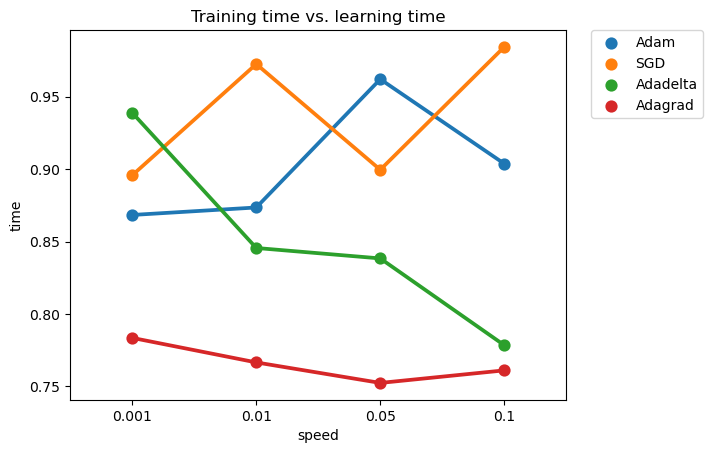

In [23]:
#Plot Training time vs. learning time
sns.pointplot(x="speed", y="time", hue="optimizer", data=histories, ci=None)
plt.title("Training time vs. learning time")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

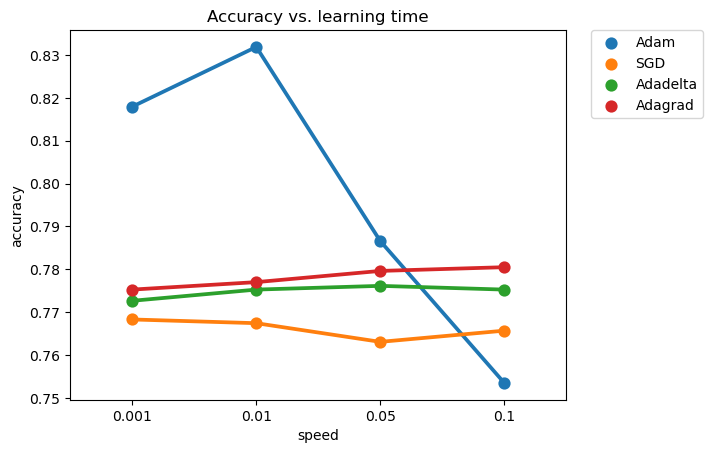

In [24]:
#Plot Accuracy vs. learning time
sns.pointplot(x="speed", y="accuracy", hue="optimizer", data=histories, ci=None)
plt.title("Accuracy vs. learning time")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

### Selection of the best model

** Attention: results may vary in each code execution! **

Based on the graphs in the previous section, we can say that the best model would be with the Adam optimizer and a learning rate of 0.01. The reasons for this choice are:

it is the model that achieves the best Accuracy.
the learning rate is not the slowest, it is intermediate.
it does not have a very fast training rate but it is not excessively high.

In [27]:
#Create, compile and fit ANN BEST model

# Create
model = Sequential()
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(3, activation="softmax"))

# Compile
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

# Fit
history = model.fit(X_train, y_train, epochs=epoch_num, batch_size=64, validation_data=(X_test, y_test), verbose = 0)

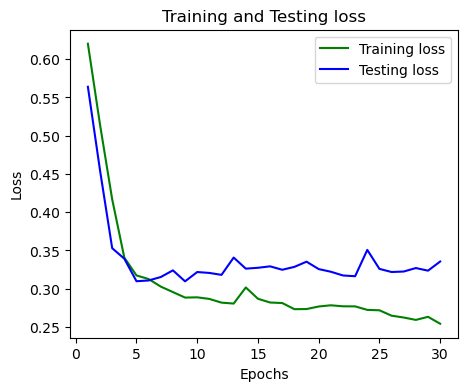

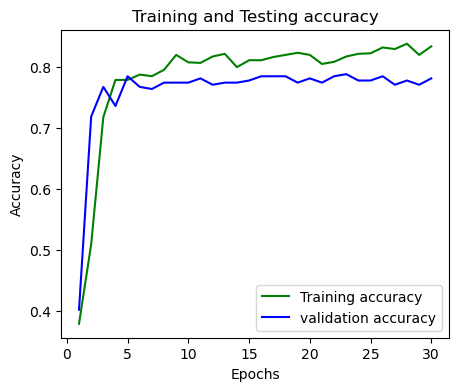

Model accuracy (Train):  0.8336237072944641 
Model accuracy (Test):  0.78125


In [28]:
#Plots
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,epoch_num+1)
plt.figure(figsize=(5, 4))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Testing loss')
plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,epoch_num+1)
plt.figure(figsize=(5, 4))
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print("Model accuracy (Train): ",history.history['accuracy'][-1], "\nModel accuracy (Test): ",history.history['val_accuracy'][-1])

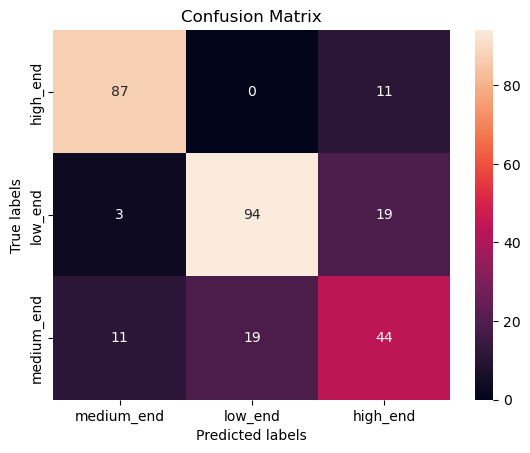

In [29]:
#Confusion matrix
y_pred = model.predict(X_test)
y_pred_original = ohe.inverse_transform(y_pred)
y_test_original = ohe.inverse_transform(y_test)

# calculate confussion matrix
matrix = confusion_matrix(y_test_original, y_pred_original)

# plot confussion matrix and the labels
ax= plt.subplot()
sns.heatmap(matrix, annot=True, fmt='g', ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['medium_end', 'low_end', 'high_end']); ax.yaxis.set_ticklabels(['high_end', 'low_end', 'medium_end']);

In [30]:
#Accuracy
accuracy = (matrix[0][0] + matrix[1][1] + matrix[2][2])/len(y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.78125


In [31]:
#Precision, Recall and F1-score for each label
tp_high_end = matrix[0][0]
fn_high_end = matrix[0][1] + matrix[0][2]
fp_high_end = matrix[1][0] + matrix[2][0]
tn_high_end = matrix[1][1] + matrix[1][2] + matrix[2][1] + matrix[2][2]
tp_low_end = matrix[1][1]
fn_low_end = matrix[1][0] + matrix[1][2]
fp_low_end = matrix[0][1] + matrix[2][1]
tn_low_end = matrix[0][0] + matrix[2][0] + matrix[0][2] + matrix[2][2]
tp_medium_end = matrix[2][2]
fn_medium_end = matrix[2][0] + matrix[2][1]
fp_medium_end = matrix[0][2] + matrix[1][2]
tn_medium_end = matrix[0][0] + matrix[0][1] + matrix[1][0] + matrix[1][1]

hep = tp_high_end/(tp_high_end+fp_high_end)
her = tp_high_end/(tp_high_end+fn_high_end)
print("high_end precision: ", hep)
print("high_end recall: ", her)
print("high_end F1-score: ", 2*hep*her/(hep+her))

lep = tp_low_end/(tp_low_end+fp_low_end)
ler = tp_low_end/(tp_low_end+fn_low_end)
print("low_end precision: ", lep)
print("low_end recall: ", ler)
print("low_end F1-score: ", 2*lep*ler/(lep+ler))

mep = tp_medium_end/(tp_medium_end+fp_medium_end)
mer = tp_medium_end/(tp_medium_end+fn_medium_end)
print("medium_end precision: ", mep)
print("medium_end recall: ", mer)
print("medium_end F1-score: ", 2*mep*mer/(mep+mer))

print(classification_report(y_test_original, y_pred_original))

high_end precision:  0.8613861386138614
high_end recall:  0.8877551020408163
high_end F1-score:  0.8743718592964823
low_end precision:  0.831858407079646
low_end recall:  0.8103448275862069
low_end F1-score:  0.8209606986899564
medium_end precision:  0.5945945945945946
medium_end recall:  0.5945945945945946
medium_end F1-score:  0.5945945945945946
              precision    recall  f1-score   support

    high-end       0.86      0.89      0.87        98
     low-end       0.83      0.81      0.82       116
  medium-end       0.59      0.59      0.59        74

    accuracy                           0.78       288
   macro avg       0.76      0.76      0.76       288
weighted avg       0.78      0.78      0.78       288



**Comment results**

Once we have seen that the best model would be with the Adam optimizer and a learning rate of 0.01, we have created, compiled, and retrained the model with these parameters, taking into account to add the test set that we had prepared, so that the training now returns the accuracy and loss for the train set and the test set.

We have graphed the results and we have seen that, in general, the validation set (test) has a worse performance compared to the results with the train set, which we believe is normal. We see that the train accuracy is 0.82 and the test accuracy is 0.78, it has dropped four points, but as we said, it is normal since the test data is new to the model.

When we print the confusion matrix, we see that we have a well-balanced matrix, where most of the elements are on the diagonal, which indicates that most of the elements have been predicted correctly. We have been able to calculate that the prediction accuracy on the test is 0.78, as we had calculated in the previous exercise.

From the analysis of the metrics of the confusion matrix, we can see that:

- the precision for high_end car prices is the best of all (0.87), followed by low_end car prices (0.83) and finally medium_end car prices (0.59). That is, the model predicts high_end prices quite well, similar low_end prices, and quite poorly medium_end prices.
- with recall, we see data in the same direction. The best recall is for high_end vehicles, followed by low_end vehicles and finally a very poor recall for medium-end vehicles. That is, of all the vehicles that are actually high-end, 86% are correctly predicted.
- since F1 is a function of precision and recall, we observe that in the f1-score the differences are maintained, with a better f1 for high_end vehicles, followed closely by low_end, while for medium-end it is quite poor.

These results indicate that the model is capable of predicting the resale prices of the "extreme" vehicles, high and low, quite well, while for medium vehicles the prediction is not as good. It is probably due to the fact that for the medium_end vehicle area there is quite a mixture of high_end and medium_end vehicles for the high side and low_end and medium_end vehicles for the low side (overlap of vehicle prices from different ranges).

## 3. Artificial Neural Network: Regression

In this section, a regression problem will be solved by attempting to predict the resale price based on the characteristics of the cars. The original data set will be used. The data will be pre-processed by creating the dependent (features) and independent (target) variable vectors and normalizing the data appropriately. The data set will then be divided into 70% for training and 30% for testing using the train_test_split function. The dimensions of the training and test sets will be displayed.

### Pre-processing

In [32]:
#Create features and target vectors
features = df.iloc[:,:9].values
target = df.iloc[:, 9].values

In [33]:
#Normalizing the data
features = StandardScaler().fit_transform(features)
scaler = StandardScaler()
scaler.fit(target.reshape(len(target),1))
target = scaler.transform(target.reshape(len(target),1))

In [34]:
#Split train-test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)

In [35]:
#Dimensions
print("train feature dimensions: ",X_train.shape)
print("train labels dimensions: ",y_train.shape)
print("test feature dimensions: ",X_test.shape)
print("test labels dimensions: ",y_test.shape)

train feature dimensions:  (1005, 9)
train labels dimensions:  (1005, 1)
test feature dimensions:  (431, 9)
test labels dimensions:  (431, 1)


### Basis model

To design a base model, the first step is to implement a neural network with three hidden layers. For model adjustment, the test data will be used as the validation set. The following steps are to be taken to implement the artificial neural network for regression:

- Design the architecture for the regression model with the following features:
    - The first hidden layer is fully connected with 128 neurons and ReLU activation.
    - Two hidden layers with 32 and 16 neurons respectively and tanh activation.
    - All layers should have a kernel_initializer in 'normal' mode.
- Compile the model using the most appropriate loss function and the Adam optimizer.
- Train the model for 50 epochs with a batch size of 32.
- Display the loss graph. The training and validation curves will be visualized on the graph.

In [36]:
#Create ANN model
model = Sequential()
model.add(Dense(128, kernel_initializer='normal', activation="relu"))
model.add(Dense(32, kernel_initializer='normal', activation="tanh"))
model.add(Dense(16, kernel_initializer='normal', activation="tanh"))
model.add(Dense(1, kernel_initializer='normal'))

In [37]:
#Compiling the model
model.compile(loss='mse', optimizer='adam')

In [38]:
#Fit model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

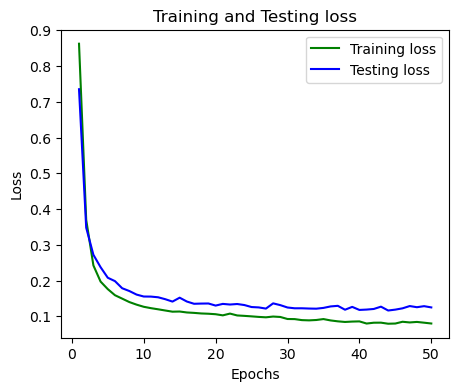

In [39]:
#Plots
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,51)
plt.figure(figsize=(5, 4))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Testing loss')
plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Hyperparameters optimization

Once we have the base model, we are interested in finding the hyperparameter configuration that provides us with a better prediction of the resale price of cars. In this section, we will perform a hyperparameter search, using different values for the number of layers, number of neurons, batch size and epochs.

A function will be implemented that evaluates different models combining the following features:
- Three different architectures with the following configurations of number of hidden layers (fully connected) and number of neurons in each layer:
    - [128, 64, 16]
    - [16, 4]
    - [4, 4]
- Batch size of 16 and 32
- Epochs of 20, 50 and 100

As in the previous parts, the first hidden layer will always have ReLU activation and the others will have tanh activation. The kernel initializer will be in 'normal' mode and we will use the Adam optimizer.

The function will provide a table with the following fields: the selected network architecture, epochs, batch size, training time and the root mean squared error (RMSE) of the model.

In [41]:
#Hiperparameter search function
def hipersearch(layers,batches,epochs):
    # initialize results dartaframe
    all_histories = pd.DataFrame({'architecture': [], 'epochs': [], 'batches': [], 'trainingTime': [], 'RMSE': []})
    
    for layer in layers:
        for batch in batches:
            for epoch in epochs:

                # create ANN model
                model = Sequential()
                model.add(Dense(layer[0], kernel_initializer='normal', activation="relu"))
                
                for i in range (1,len(layer)):
                    model.add(Dense(layer[i], kernel_initializer='normal', activation="tanh"))
                
                model.add(Dense(1, kernel_initializer='normal'))
                
                # compile model
                model.compile(loss='mse', optimizer='adam', metrics=[RootMeanSquaredError()])
                
                # train and chrono
                start=timeit.default_timer()
                history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch, verbose = 0)
                end=timeit.default_timer()
                
                # save all variables to tuple
                new_row = pd.DataFrame({'architecture': [layer], 'epochs': [epoch], 'batches': [batch], 'trainingTime': [end-start],
                                        'RMSE': [history.history['root_mean_squared_error'][-1]]})
                all_histories = pd.concat([all_histories, new_row], ignore_index = True, axis = 0)
                
    # return results        
    return all_histories

In [42]:
#Compute search
layers = [(128,64,16), (16,4), (4,4)]
batches = [16,32]
epochs = [20,50,100]
histories = hipersearch(layers,batches,epochs)
histories

,architecture,epochs,batches,trainingTime,RMSE
0,"(128, 64, 16)",20.0,16.0,1.763292,0.321619
1,"(128, 64, 16)",50.0,16.0,3.042528,0.269599
2,"(128, 64, 16)",100.0,16.0,5.504729,0.250091
3,"(128, 64, 16)",20.0,32.0,0.927903,0.323284
4,"(128, 64, 16)",50.0,32.0,1.932220,0.279237
5,"(128, 64, 16)",100.0,32.0,3.446791,0.249286
6,"(16, 4)",20.0,16.0,1.524979,0.364977
7,"(16, 4)",50.0,16.0,2.466788,0.323248
8,"(16, 4)",100.0,16.0,4.406448,0.295329
9,"(16, 4)",20.0,32.0,0.693316,0.412396


<AxesSubplot:xlabel='index', ylabel='RMSE'>

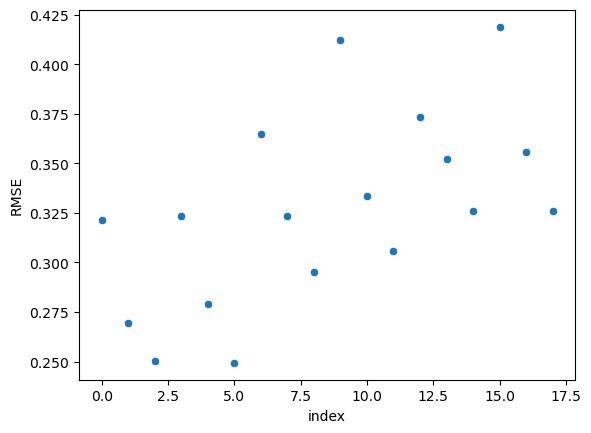

In [43]:
#Plot
sns.scatterplot(data=histories.reset_index(), x="index", y="RMSE")

**Best configuration justification**

According to the chart in the previous figure, it can be stated that the best model is number 5 (the sixth) because it has a lower RMSE than all others. The model corresponds to:

- Layers: [128,64,16]
- Batches: 32
- Epochs: 100

In [44]:
#Create, compile and fit ANN best model

# create model
model = Sequential()
model.add(Dense(128, kernel_initializer='normal', activation="relu"))
model.add(Dense(64, kernel_initializer='normal', activation="tanh"))
model.add(Dense(16, kernel_initializer='normal', activation="tanh"))
model.add(Dense(1, kernel_initializer='normal'))

# compile model
model.compile(loss='mse', optimizer='adam', metrics=[RootMeanSquaredError()])
                
# fit
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

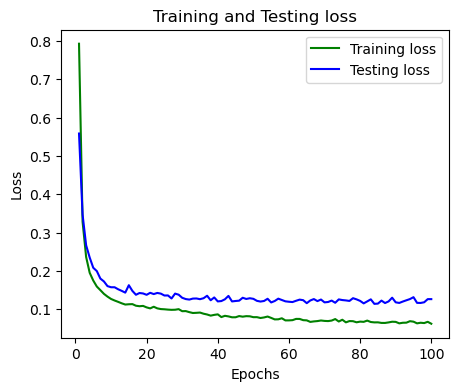

In [45]:
#Plot
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,101)
plt.figure(figsize=(5, 4))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Testing loss')
plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [46]:
#Generate Predictions on testing data, activation=
y_pred = model.predict(X_test)
y_pred_orig = scaler.inverse_transform(y_pred)
y_pred_orig = [item for sublist in y_pred_orig for item in sublist]
y_test_orig = scaler.inverse_transform(y_test)
y_test_orig = [item for sublist in y_test_orig for item in sublist]

dataset = pd.DataFrame({'y test': y_test_orig, 'y predicted': y_pred_orig})
print("Training RMSE: ", history.history['root_mean_squared_error'][-1], "\nValidation RMSE: ", history.history['val_root_mean_squared_error'][-1])
print("Test normalized RMSE: ", history.history['val_root_mean_squared_error'][-1]/(max(y_test_orig) - min(y_test_orig)))
dataset.head(10)

Training RMSE:  0.24948550760746002 
Validation RMSE:  0.3555068075656891
Test normalized RMSE:  1.3046121378557397e-05


,y test,y predicted
0,8500.0,9230.414062
1,9750.0,11752.919922
2,9750.0,11710.744141
3,9000.0,10972.760742
4,21950.0,22181.705078
5,14950.0,16209.237305
6,11500.0,10598.159180
7,13700.0,14745.191406
8,11900.0,11867.333008
9,11950.0,11575.105469


**Final comments**

Once the base model was trained, the function "hipersearch()" was created to pass as parameters the different neural network architectures, batches, and epochs. Once the function was executed, it displays a table where the RMSE of each combination can be observed. Plotting the final RMSEs for each combination shows that the model with the lowest RMSE consists of:

- Layers: [128, 64, 16]
- Batches: 32
- Epochs: 100

The model was trained with the previous architecture, batches, and epochs and the loss curve was observed. It was seen that, as expected, the final loss in the test set is worse than in the training set (since these are new, untrained data). If a prediction of resale prices is made, the model predicts the actual prices with a certain good approximation. It is a fairly accurate prediction. In fact, knowing that the price values are in tens of thousands of euros, having an RMSE of 0.35 indicates that the prediction is very good. The code contemplates the normalization of the RMSE, which indicates whether a model is good or not, regardless of the dimensionality of the data. The closer to 0, the better it predicts. If it is 1, it predicts very poorly. In our case, it gave us 1.3011665519224394e-05, which indicates that the model is an excellent predictor.